

# *   Install Libary and install ByteTrack



In [ ]:
!pip install ipympl
!pip install supervision==0.14.0
!pip install numpy==1.23.5

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

!pip install ultralytics
!pip install -q loguru lap thop
!pip install -q onemetric

In [ ]:
%cd /content/drive/MyDrive

In [ ]:
!pip install gdown==5.1.0
# == Download the repo content and install dependencies ==
!git clone https://github.com/ifzhang/ByteTrack.git
%cd  /content/drive/MyDrive/ByteTrack/
%mkdir pretrained
%cd pretrained

# == Download pretrained X model weights ==
!gdown --id "1P4mY0Yyd3PPTybgZkjMYhFri88nTmJX5"

In [ ]:
# == Install dependencies ==
!pip3 install cython
!pip3 install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip3 install cython_bbox

%cd  /content/drive/MyDrive/ByteTrack/
!pip3 install -r requirements.txt

In [ ]:
# == Install ByteTrack ==
!python3 setup.py develop

# Download và cài đặt model đã train

In [ ]:
%cd /content/drive/MyDrive
!gdown 1Vf54yLkNsycQnYKM1JXnCBeEXFfIpIUE
# 1vL3OAw50u-_gzjprmP-AOmwwCdc65Qcd

/content/drive/MyDrive
Downloading...
From (original): https://drive.google.com/uc?id=1Vf54yLkNsycQnYKM1JXnCBeEXFfIpIUE
From (redirected): https://drive.usercontent.google.com/download?id=1Vf54yLkNsycQnYKM1JXnCBeEXFfIpIUE&confirm=t&uuid=0ac1395f-0c74-42b3-abd6-d77f9a3d0362
To: /content/drive/MyDrive/best.pt
100% 51.6M/51.6M [00:01<00:00, 39.6MB/s]


In [ ]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/yolov8n_60e.pt")
model.fuse()

Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


In [ ]:
%cd /content/drive/MyDrive/ByteTrack/

/content/drive/MyDrive/ByteTrack


#  Vẽ bouding box và tracking

In [ ]:
from typing import List

import numpy as np
from supervision import Detections
from onemetric.cv.utils.iou import box_iou_batch
from yolox.tracker.byte_tracker import BYTETracker, STrack



# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

# Các bước thực hiện vẽ Line để counting

### Color

In [ ]:
from supervision import (
    ColorPalette,
    Point,
    get_video_frames_generator,
    VideoInfo,
    VideoSink
)

In [ ]:
class Color:
    """
    A simple class representing RGB color.
    """

    def __init__(self, red: int, green: int, blue: int):
        """
        Initialize a Color object.

        Attributes:
            red (int): The red component of the color (0-255).
            green (int): The green component of the color (0-255).
            blue (int): The blue component of the color (0-255).

        """
        self.red = red
        self.green = green
        self.blue = blue

    def as_bgr(self):
        """
        Convert the color to BGR format for OpenCV.

        Returns:
            Tuple[int, int, int]: The BGR representation of the color.

        """
        return self.blue, self.green, self.red

    @classmethod
    def white(cls):
        """
        Get the color white.

        Returns:
            Color: The white color.

        """
        return cls(255, 255, 255)

    @classmethod
    def yellow(cls):
        """
        Get the color yellow.

        Returns:
            Color: The yellow color.

        """
        return cls(255, 255, 0)

    @classmethod
    def red(cls):
        """
        Get the color red.

        Returns:
            Color: The red color.

        """
        return cls(255, 0, 0)

    @classmethod
    def green(cls):
        """
        Get the color green.

        Returns:
            Color: The green color.

        """
        return cls(0, 255, 0)

    @classmethod
    def blue(cls):
        """
        Get the color blue.

        Returns:
            Color: The blue color.

        """
        return cls(0, 0, 255)


### Đây là phần tính out

In [ ]:
from typing import Dict, Optional

import cv2
import numpy as np

from supervision.detection.core import Detections
from supervision.draw.color import Color
from supervision.geometry.core import Point, Rect, Vector

class LineZone:
    """
    Count the number of objects that cross a line.
    """

    def __init__(self, start: Point, end: Point):
        """
        Initialize a LineZone object.

        Attributes:
            start (Point): The starting point of the line.
            end (Point): The ending point of the line.

        """
        self.vector = Vector(start=start, end=end)
        self.tracker_state: Dict[str, bool] = {}
        self.in_count: int = 0
        self.out_person_count: int = 0
        self.out_object_count: int = 0
        self.total_out_count: int = 0

    def trigger(self, detections: Detections):
        """
        Update the in_count and out_count for the detections that cross the line.

        Attributes:
            detections (Detections): The detections for which to update the counts.

        """
        for xyxy, _, confidence, class_id, tracker_id in detections:
            # handle detections with no tracker_id
            if tracker_id is None:
                continue

            # we check if all four anchors of bbox are on the same side of vector
            x1, y1, x2, y2 = xyxy
            anchors = [
                Point(x=x1, y=y1),
                Point(x=x1, y=y2),
                Point(x=x2, y=y1),
                Point(x=x2, y=y2),
            ]
            triggers = [self.vector.is_in(point=anchor) for anchor in anchors]

            # detection is partially in and partially out
            if len(set(triggers)) == 2:
                continue

            tracker_state = triggers[0]
            # handle new detection
            if tracker_id not in self.tracker_state:
                self.tracker_state[tracker_id] = tracker_state
                continue

            # handle detection on the same side of the line
            if self.tracker_state.get(tracker_id) == tracker_state:
                continue

            self.tracker_state[tracker_id] = tracker_state
            if tracker_state:
                self.in_count += 1
            else:
                # Check if class_id is in the list of classes you're interested in
                if class_id in classes:
                    if class_id == 1:  # Assume 1 corresponds to 'Person'
                        self.out_person_count += 1
                    else:
                        self.out_object_count += 1

        # Update total out count
        self.total_out_count = self.out_person_count + self.out_object_count

In [ ]:
class LineZoneAnnotator:
    def __init__(
        self,
        thickness: float = 2,
        text_thickness: float = 2,
        text_scale: float = 0.5,
        text_offset: float = 1.5,
        text_padding: int = 10,
    ):
        """
        Initialize the LineZoneAnnotator object with default values.

        Attributes:
            thickness (float): The thickness of the line that will be drawn.
            text_thickness (float): The thickness of the text that will be drawn.
            text_scale (float): The scale of the text that will be drawn.
            text_offset (float): The offset of the text that will be drawn.
            text_padding (int): The padding of the text that will be drawn.

        """
        self.thickness: float = thickness
        self.text_thickness: float = text_thickness
        self.text_scale: float = text_scale
        self.text_offset: float = text_offset
        self.text_padding: int = text_padding

    def annotate(self, frame: np.ndarray, line_zone: LineZone) -> np.ndarray:
        # Draw the line
        cv2.line(
            frame,
            line_zone.vector.start.as_xy_int_tuple(),
            line_zone.vector.end.as_xy_int_tuple(),
            Color.white().as_bgr(),
            self.thickness,
            lineType=cv2.LINE_AA,
            shift=0,
        )

        # Draw the left-side table
        table_width = 60
        table_height = 60

        # Define colors for each column
        out_person_color = Color.blue()
        out_object_color = Color.green()
        total_out_color = Color.red()

        # Draw rectangles for each column
        out_person_rect = Rect(0, 0, table_width, table_height)
        out_object_rect = Rect(table_width, 0, table_width, table_height)
        total_out_rect = Rect(2 * table_width, 0, table_width, table_height)

        cv2.rectangle(
            frame,
            out_person_rect.top_left.as_xy_int_tuple(),
            out_person_rect.bottom_right.as_xy_int_tuple(),
            out_person_color.as_bgr(),
            -1,
        )
        cv2.rectangle(
            frame,
            out_object_rect.top_left.as_xy_int_tuple(),
            out_object_rect.bottom_right.as_xy_int_tuple(),
            out_object_color.as_bgr(),
            -1,
        )
        cv2.rectangle(
            frame,
            total_out_rect.top_left.as_xy_int_tuple(),
            total_out_rect.bottom_right.as_xy_int_tuple(),
            total_out_color.as_bgr(),
            -1,
        )

        # Draw text on the table
        out_person_text = f"{line_zone.out_person_count}"
        out_object_text = f"{line_zone.out_object_count}"
        total_out_text = f"{line_zone.total_out_count}"

        # Calculate text positions
        text_y = 40  # Adjust as needed
        text_spacing = 100

        out_person_text_x = table_width // 2 - int(len(out_person_text) * 2.5) - 10
        out_object_text_x = table_width + table_width // 2 - int(len(out_object_text) * 2.5)- 10
        total_out_text_x = 2 * table_width + table_width // 2 - int(len(total_out_text) * 2.5)- 10

        # Draw text
        cv2.putText(
            frame,
            out_person_text,
            (out_person_text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            self.text_scale,
            Color.white().as_bgr(),
            self.text_thickness,
            cv2.LINE_AA,
        )
        cv2.putText(
            frame,
            out_object_text,
            (out_object_text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            self.text_scale,
            Color.white().as_bgr(),
            self.text_thickness,
            cv2.LINE_AA,
        )
        cv2.putText(
            frame,
            total_out_text,
            (total_out_text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            self.text_scale,
            Color.white().as_bgr(),
            self.text_thickness,
            cv2.LINE_AA,
        )

        return frame

### Tính IN

In [ ]:
from typing import Dict, Optional

import cv2
import numpy as np

from supervision.detection.core import Detections
from supervision.draw.color import Color
from supervision.geometry.core import Point, Rect, Vector

class LineZone:
    """
    Count the number of objects that cross a line.
    """

    def __init__(self, start: Point, end: Point):
        """
        Initialize a LineZone object.

        Attributes:
            start (Point): The starting point of the line.
            end (Point): The ending point of the line.

        """
        self.vector = Vector(start=start, end=end)
        self.tracker_state: Dict[str, bool] = {}
        self.out_count: int = 0
        self.in_person_count: int = 0
        self.in_object_count: int = 0
        self.total_in_count: int = 0

    def trigger(self, detections: Detections):
        """
        Update the in_count and out_count for the detections that cross the line.

        Attributes:
            detections (Detections): The detections for which to update the counts.

        """
        for xyxy, _, confidence, class_id, tracker_id in detections:
            # handle detections with no tracker_id
            if tracker_id is None:
                continue

            # we check if all four anchors of bbox are on the same side of vector
            x1, y1, x2, y2 = xyxy
            anchors = [
                Point(x=x1, y=y1),
                Point(x=x1, y=y2),
                Point(x=x2, y=y1),
                Point(x=x2, y=y2),
            ]
            triggers = [self.vector.is_in(point=anchor) for anchor in anchors]

            # detection is partially in and partially out
            if len(set(triggers)) == 2:
                continue

            tracker_state = triggers[0]
            # handle new detection
            if tracker_id not in self.tracker_state:
                self.tracker_state[tracker_id] = tracker_state
                continue

            # handle detection on the same side of the line
            if self.tracker_state.get(tracker_id) == tracker_state:
                continue

            self.tracker_state[tracker_id] = tracker_state
            if tracker_state:
                if class_id in classes:
                    if class_id == 1:  # Assume 1 corresponds to 'Person'
                        self.in_person_count += 1
                    else:
                        self.in_object_count += 1
            else:
                # Check if class_id is in the list of classes you're interested in
                self.out_count += 1

        # Update total out count
        self.total_in_count = self.in_person_count + self.in_object_count

In [ ]:
class LineZoneAnnotator:
    def __init__(
        self,
        thickness: float = 2,
        text_thickness: float = 2,
        text_scale: float = 0.5,
        text_offset: float = 1.5,
        text_padding: int = 10,
    ):
        """
        Initialize the LineZoneAnnotator object with default values.

        Attributes:
            thickness (float): The thickness of the line that will be drawn.
            text_thickness (float): The thickness of the text that will be drawn.
            text_scale (float): The scale of the text that will be drawn.
            text_offset (float): The offset of the text that will be drawn.
            text_padding (int): The padding of the text that will be drawn.

        """
        self.thickness: float = thickness
        self.text_thickness: float = text_thickness
        self.text_scale: float = text_scale
        self.text_offset: float = text_offset
        self.text_padding: int = text_padding

    def annotate(self, frame: np.ndarray, line_zone: LineZone) -> np.ndarray:
        # Draw the line
        cv2.line(
            frame,
            line_zone.vector.start.as_xy_int_tuple(),
            line_zone.vector.end.as_xy_int_tuple(),
            Color.white().as_bgr(),
            self.thickness,
            lineType=cv2.LINE_AA,
            shift=0,
        )

        # Draw the left-side table
        table_width = 60
        table_height = 60

        # Define colors for each column
        in_person_color = Color.blue()
        in_object_color = Color.green()
        total_in_color = Color.red()

        # Draw rectangles for each column
        in_person_rect = Rect(0, 0, table_width, table_height)
        in_object_rect = Rect(table_width, 0, table_width, table_height)
        total_in_rect = Rect(2 * table_width, 0, table_width, table_height)

        cv2.rectangle(
            frame,
            in_person_rect.top_left.as_xy_int_tuple(),
            in_person_rect.bottom_right.as_xy_int_tuple(),
            in_person_color.as_bgr(),
            -1,
        )
        cv2.rectangle(
            frame,
            in_object_rect.top_left.as_xy_int_tuple(),
            in_object_rect.bottom_right.as_xy_int_tuple(),
            in_object_color.as_bgr(),
            -1,
        )
        cv2.rectangle(
            frame,
            total_in_rect.top_left.as_xy_int_tuple(),
            total_in_rect.bottom_right.as_xy_int_tuple(),
            total_in_color.as_bgr(),
            -1,
        )

        # Draw text on the table
        in_person_text = f"{line_zone.in_person_count}"
        in_object_text = f"{line_zone.in_object_count}"
        total_in_text = f"{line_zone.total_in_count}"

        # Calculate text positions
        text_y = 40  # Adjust as needed
        text_spacing = 100

        out_person_text_x = table_width // 2 - int(len(in_person_text) * 2.5) - 10
        out_object_text_x = table_width + table_width // 2 - int(len(in_object_text) * 2.5)- 10
        total_out_text_x = 2 * table_width + table_width // 2 - int(len(total_in_text) * 2.5)- 10

        # Draw text
        cv2.putText(
            frame,
            in_person_text,
            (out_person_text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            self.text_scale,
            Color.white().as_bgr(),
            self.text_thickness,
            cv2.LINE_AA,
        )
        cv2.putText(
            frame,
            in_object_text,
            (out_object_text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            self.text_scale,
            Color.white().as_bgr(),
            self.text_thickness,
            cv2.LINE_AA,
        )
        cv2.putText(
            frame,
            total_in_text,
            (total_out_text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            self.text_scale,
            Color.white().as_bgr(),
            self.text_thickness,
            cv2.LINE_AA,
        )

        return frame

### Tính total

In [ ]:
from typing import Dict, Optional

import cv2
import numpy as np

from supervision.detection.core import Detections
from supervision.geometry.core import Point, Rect, Vector

class LineZone:
    """
    Count the number of objects that cross a line.
    """

    def __init__(self, start: Point, end: Point):
        """
        Initialize a LineZone object.

        Attributes:
            start (Point): The starting point of the line.
            end (Point): The ending point of the line.

        """
        self.vector = Vector(start=start, end=end)
        self.tracker_state: Dict[str, bool] = {}
        self.total_in_count: int = 0
        self.total_out_count: int = 0

    def trigger(self, detections: Detections):
        """
        Update the in_count and out_count for the detections that cross the line.

        Attributes:
            detections (Detections): The detections for which to update the counts.

        """
        for xyxy, _, confidence, class_id, tracker_id in detections:
            # handle detections with no tracker_id
            if tracker_id is None:
                continue

            # we check if all four anchors of bbox are on the same side of vector
            x1, y1, x2, y2 = xyxy
            anchors = [
                Point(x=x1, y=y1),
                Point(x=x1, y=y2),
                Point(x=x2, y=y1),
                Point(x=x2, y=y2),
            ]
            triggers = [self.vector.is_in(point=anchor) for anchor in anchors]

            # detection is partially in and partially out
            if len(set(triggers)) == 2:
                continue

            tracker_state = triggers[0]
            # handle new detection
            if tracker_id not in self.tracker_state:
                self.tracker_state[tracker_id] = tracker_state
                continue

            # handle detection on the same side of the line
            if self.tracker_state.get(tracker_id) == tracker_state:
                continue

            self.tracker_state[tracker_id] = tracker_state
            if tracker_state:
                self.total_in_count += 1
            else:
                self.total_out_count += 1

In [ ]:
class LineZoneAnnotator:
    def __init__(
        self,
        thickness: float = 2,
        text_thickness: float = 2,
        text_scale: float = 0.5,
        text_offset: float = 1.5,
        text_padding: int = 10,
    ):
        """
        Initialize the LineZoneAnnotator object with default values.

        Attributes:
            thickness (float): The thickness of the line that will be drawn.
            text_thickness (float): The thickness of the text that will be drawn.
            text_scale (float): The scale of the text that will be drawn.
            text_offset (float): The offset of the text that will be drawn.
            text_padding (int): The padding of the text that will be drawn.

        """
        self.thickness: float = thickness
        self.text_thickness: float = text_thickness
        self.text_scale: float = text_scale
        self.text_offset: float = text_offset
        self.text_padding: int = text_padding

    def annotate(self, frame: np.ndarray, line_zone: LineZone) -> np.ndarray:
        # Draw the line
        cv2.line(
            frame,
            line_zone.vector.start.as_xy_int_tuple(),
            line_zone.vector.end.as_xy_int_tuple(),
            Color.white().as_bgr(),
            self.thickness,
            lineType=cv2.LINE_AA,
            shift=0,
        )

        # Draw the left-side table
        table_width = 60
        table_height = 60

        # Define colors for each column
        total_in_color = Color.red()
        total_out_color = Color.green()

        # Draw rectangles for each column
        total_in_rect = Rect(0, 0, table_width, table_height)
        total_out_rect = Rect(table_width, 0, table_width, table_height)

        cv2.rectangle(
            frame,
            total_in_rect.top_left.as_xy_int_tuple(),
            total_in_rect.bottom_right.as_xy_int_tuple(),
            total_in_color.as_bgr(),
            -1,
        )
        cv2.rectangle(
            frame,
            total_out_rect.top_left.as_xy_int_tuple(),
            total_out_rect.bottom_right.as_xy_int_tuple(),
            total_out_color.as_bgr(),
            -1,
        )

        # Draw text on the table
        total_in_text = f"{line_zone.total_in_count}"
        total_out_text = f"{line_zone.total_out_count}"

        # Calculate text positions
        text_y = 40  # Adjust as needed
        text_spacing = 100

        total_in_text_x = table_width // 2 - int(len(total_in_text) * 2.5) - 10
        total_out_text_x = table_width + table_width // 2 - int(len(total_out_text) * 2.5) - 10

        # Draw text
        cv2.putText(
            frame,
            total_in_text,
            (total_in_text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            self.text_scale,
            Color.white().as_bgr(),
            self.text_thickness,
            cv2.LINE_AA,
        )
        cv2.putText(
            frame,
            total_out_text,
            (total_out_text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            self.text_scale,
            Color.white().as_bgr(),
            self.text_thickness,
            cv2.LINE_AA,
        )

        return frame


# Preprocessing Video and model

In [ ]:
def get_video_shape(video_path):
    generator = get_video_frames_generator(video_path)
    iterator = iter(generator)
    frame = next(iterator)
    return frame.shape

In [ ]:
id= "1GUL-wD-A3QxFPzer-KrlszxkMv7tqWfL"
source_video_path = "source1.mp4"
!gdown {id} -O {source_video_path}

Downloading...
From: https://drive.google.com/uc?id=1GUL-wD-A3QxFPzer-KrlszxkMv7tqWfL
To: /content/drive/MyDrive/ByteTrack/source1.mp4
100% 15.9M/15.9M [00:00<00:00, 26.4MB/s]


In [ ]:
class_names_dict = model.model.names
classes = [0, 1]

scaled_video_path = "resized1.mp4"
target_video_path = "result1.mp4"

thickness = 1
text_thickness = 1
text_scale = 1

get_video_shape(source_video_path)

(720, 1280, 3)

In [ ]:
scale_ratio = 0.7
width, height = get_video_shape(source_video_path)[:2]
scaled_size = f"scale={int(height*scale_ratio/2) * 2}:{int(width*scale_ratio/2) * 2}"

!ffmpeg -i {source_video_path} -crf 18 -preset veryfast \
        -hide_banner -loglevel error \
        -vf {scaled_size} -vcodec libx264 {scaled_video_path} -y

get_video_shape(scaled_video_path)

(502, 896, 3)

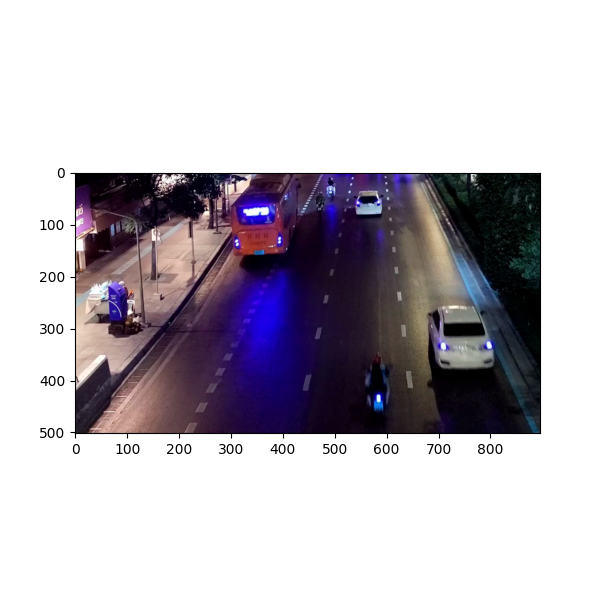

Point(260, 164)
Point(262, 162)
Point(813, 137)


In [ ]:
# Đay là bước chọn Point trực tiếp từ frame
%matplotlib ipympl
import matplotlib
import matplotlib.pyplot as plt

generator = get_video_frames_generator(scaled_video_path)

iterator = iter(generator)
frame = next(iterator)

fig = plt.figure(figsize=(6, 6))
plt.imshow(frame)

def on_click(event):
    ix, iy = event.xdata, event.ydata
    print(f"Point({round(ix)}, {round(iy)})")

cid = fig.canvas.mpl_connect('button_press_event', on_click)

In [ ]:
%%capture
%matplotlib inline

line_start = Point(262, 162)
line_end = Point(813, 137)

# Change mode and clear output
plt.figure(figsize=(10, 10))
plt.show()

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [  4,  12,  11],
        [  2,  19,  17],
        [  5,  22,  20]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [  3,  11,  10],
        [  0,  17,  15],
        [  0,  15,  13]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [  0,   7,   6],
        [  3,  11,  10],
        [  4,  12,  11]],

       ...,

       [[ 35,  28,  39],
        [ 48,  41,  52],
        [ 47,  40,  51],
        ...,
        [ 41,  72,  88],
        [ 36,  57,  70],
        [ 36,  57,  70]],

       [[ 40,  33,  44],
        [ 46,  39,  50],
        [ 45,  38,  49],
        ...,
        [ 50,  81,  97],
        [ 45,  66,  79],
        [ 32,  53,  66]],

       [[ 41,  34,  45],
        [ 46,  39,  50],
        [ 42,  35,  46],
        ...,
        [ 57,  88, 104],
        [ 51,  72,  85],
        [ 32,  53,  66]]], dtype=uint8)
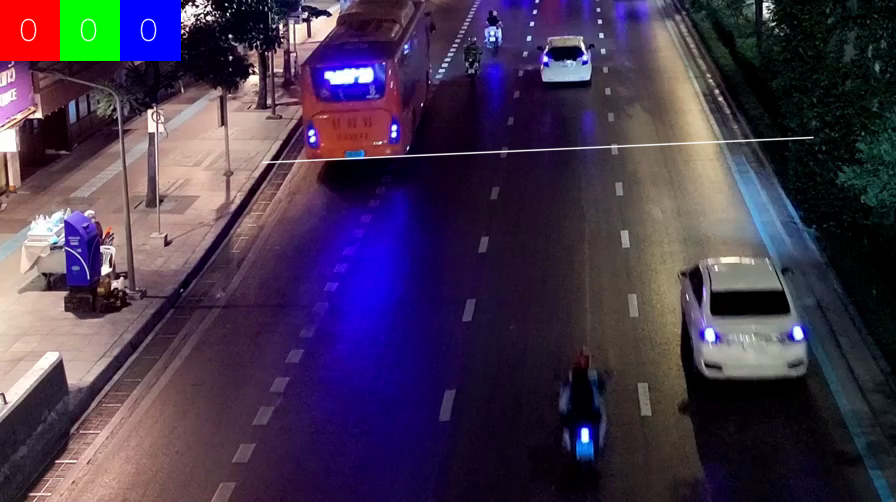

In [ ]:
line_counter = LineZone(start=line_start, end=line_end)
line_annotator = LineZoneAnnotator(thickness=thickness,
                                   text_thickness=text_thickness,
                                   text_scale=text_scale)
line_annotator.annotate(frame=frame, line_zone=line_counter)

# Tinh chỉnh siêu tham số và thưc hiện tracking và counting

In [ ]:
from dataclasses import dataclass
from onemetric.cv.utils.iou import box_iou_batch
from yolox.tracker.byte_tracker import BYTETracker, STrack

@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False
byte_tracker = BYTETracker(BYTETrackerArgs())

In [ ]:
# Đây là 1 hàm có trong byte_track
def frame2detections(model, frame, tracker):
    results = model(frame, verbose=False)
    detections = Detections(
        xyxy=results[0].boxes.xyxy.cpu().numpy(),
        confidence=results[0].boxes.conf.cpu().numpy(),
        class_id=results[0].boxes.cls.cpu().numpy().astype(int)
    )


    tracks = tracker.update(
        output_results=detections2boxes(detections=detections),
        img_info=frame.shape,
        img_size=frame.shape
    )
    tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
    detections.tracker_id = np.array(tracker_id)

    mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
    detections = detections[mask]

    return detections

In [ ]:
from supervision.draw.color import Color
from typing import List, Optional, Union

class BoxAnnotator:
    """
    A class for drawing bounding boxes on an image using detections provided.

    Attributes:
        color (Union[Color, ColorPalette]): The color to draw the bounding box,
            can be a single color or a color palette
        thickness (int): The thickness of the bounding box lines, default is 2
        text_color (Color): The color of the text on the bounding box, default is white
        text_scale (float): The scale of the text on the bounding box, default is 0.5
        text_thickness (int): The thickness of the text on the bounding box,
            default is 1
        text_padding (int): The padding around the text on the bounding box,
            default is 5

    """

    def __init__(
        self,
        color: Union[Color, ColorPalette] = ColorPalette.default(),
        thickness: int = 2,
        text_color: Color = Color.black(),
        text_scale: float = 0.5,
        text_thickness: int = 1,
        text_padding: int = 10,
    ):
        self.color: Union[Color, ColorPalette] = color
        self.thickness: int = thickness
        self.text_color: Color = text_color
        self.text_scale: float = text_scale
        self.text_thickness: int = text_thickness
        self.text_padding: int = text_padding

    def annotate(
        self,
        scene: np.ndarray,
        detections: Detections,
        labels: Optional[List[str]] = None,
        skip_label: bool = False,
    ) -> np.ndarray:
        """
        Draws bounding boxes on the frame using the detections provided.

        Args:
            scene (np.ndarray): The image on which the bounding boxes will be drawn
            detections (Detections): The detections for which the
                bounding boxes will be drawn
            labels (Optional[List[str]]): An optional list of labels
                corresponding to each detection. If `labels` are not provided,
                corresponding `class_id` will be used as label.
            skip_label (bool): Is set to `True`, skips bounding box label annotation.
        Returns:
            np.ndarray: The image with the bounding boxes drawn on it

        Example:
            ```python
            >>> import supervision as sv

            >>> classes = ['person', ...]
            >>> image = ...
            >>> detections = sv.Detections(...)

            >>> box_annotator = sv.BoxAnnotator()
            >>> labels = [
            ...     f"{classes[class_id]} {confidence:0.2f}"
            ...     for _, _, confidence, class_id, _
            ...     in detections
            ... ]
            >>> annotated_frame = box_annotator.annotate(
            ...     scene=image.copy(),
            ...     detections=detections,
            ...     labels=labels
            ... )
            ```
        """
        font = cv2.FONT_HERSHEY_SIMPLEX
        # for i in range(len(detections)):
        #     x1, y1, x2, y2 = detections.xyxy[i].astype(int)
        #     class_id = (
        #         detections.class_id[i] if detections.class_id is not None else None
        #     )
        #     idx = class_id if class_id is not None else i
        #     color = (
        #         self.color.by_idx(idx)
        #         if isinstance(self.color, ColorPalette)
        #         else self.color
        #     )
        #     cv2.rectangle(
        #         img=scene,
        #         pt1=(x1, y1),
        #         pt2=(x2, y2),
        #         color=color.as_bgr(),
        #         thickness=self.thickness,
        #     )
        #     if skip_label:
        #         continue

        #     text = (
        #         f"{class_id}"
        #         if (labels is None or len(detections) != len(labels))
        #         else labels[i]
        #     )

        #     text_width, text_height = cv2.getTextSize(
        #         text=text,
        #         fontFace=font,
        #         fontScale=self.text_scale,  # Adjust this parameter to change text size
        #         thickness=self.text_thickness,
        #     )[0]

        #     text_x = x1 + self.text_padding
        #     text_y = y1 - self.text_padding

        #     text_background_x1 = x1
        #     text_background_y1 = y1 - 2 * self.text_padding - text_height

        #     text_background_x2 = x1 + 2 * self.text_padding + text_width
        #     text_background_y2 = y1

        #     cv2.putText(
        #         img=scene,
        #         text=text,
        #         org=(text_x, text_y),
        #         fontFace=font,
        #         fontScale=self.text_scale,  # Adjust this parameter to change text size
        #         color=self.text_color.as_rgb(),
        #         thickness=self.text_thickness,
        #         lineType=cv2.LINE_AA,
        #     )

        # return scene
        for i in range(len(detections)):
            x1, y1, x2, y2 = detections.xyxy[i].astype(int)
            class_id = (
                detections.class_id[i] if detections.class_id is not None else None
            )
            idx = class_id if class_id is not None else i
            color = (
                self.color.by_idx(idx)
                if isinstance(self.color, ColorPalette)
                else self.color
            )
            cv2.rectangle(
                img=scene,
                pt1=(x1, y1),
                pt2=(x2, y2),
                color=color.as_bgr(),
                thickness=self.thickness,
            )
            if skip_label:
                continue

            if labels is not None and len(detections) == len(labels):
                text = labels[i]
            else:
                text = str(class_id)

            text_width, text_height = cv2.getTextSize(
                text=text,
                fontFace=font,
                fontScale=self.text_scale,
                thickness=self.text_thickness,
            )[0]

            text_x = x1 + self.text_padding
            text_y = y1 - self.text_padding

            cv2.putText(
                img=scene,
                text=text,
                org=(text_x, text_y),
                fontFace=font,
                fontScale=self.text_scale,
                color=self.text_color.as_rgb(),
                thickness=self.text_thickness,
                lineType=cv2.LINE_AA,
            )
        return scene


class MaskAnnotator:
    """
    A class for overlaying masks on an image using detections provided.

    Attributes:
        color (Union[Color, ColorPalette]): The color to fill the mask,
            can be a single color or a color palette
    """

    def __init__(
        self,
        color: Union[Color, ColorPalette] = ColorPalette.default(),
    ):
        self.color: Union[Color, ColorPalette] = color

    def annotate(
        self, scene: np.ndarray, detections: Detections, opacity: float = 0.5
    ) -> np.ndarray:
        """
        Overlays the masks on the given image based on the provided detections,
            with a specified opacity.

        Args:
            scene (np.ndarray): The image on which the masks will be overlaid
            detections (Detections): The detections for which the
                masks will be overlaid
            opacity (float): The opacity of the masks, between 0 and 1, default is 0.5

        Returns:
            np.ndarray: The image with the masks overlaid
        """
        if detections.mask is None:
            return scene

        for i in np.flip(np.argsort(detections.area)):
            class_id = (
                detections.class_id[i] if detections.class_id is not None else None
            )
            idx = class_id if class_id is not None else i
            color = (
                self.color.by_idx(idx)
                if isinstance(self.color, ColorPalette)
                else self.color
            )

            mask = detections.mask[i]
            colored_mask = np.zeros_like(scene, dtype=np.uint8)
            colored_mask[:] = color.as_bgr()

            scene = np.where(
                np.expand_dims(mask, axis=-1),
                np.uint8(opacity * colored_mask + (1 - opacity) * scene),
                scene,
            )

        return scene

# Thực hiện tracking and xuất video

In [ ]:
from tqdm.notebook import tqdm

box_annotator = BoxAnnotator(color=ColorPalette.default(),
                             thickness=thickness,
                             text_thickness=text_thickness,
                             text_scale=0.8)

line_counter = LineZone(start=line_start, end=line_end)
line_annotator = LineZoneAnnotator(thickness=thickness,
                                   text_thickness=text_thickness,
                                   text_scale=text_scale)

video_info = VideoInfo.from_video_path(scaled_video_path)
with VideoSink(target_video_path, video_info) as sink:
    generator = get_video_frames_generator(scaled_video_path)
    for frame in tqdm(generator, total=video_info.total_frames):
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        # mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        # detections.filter(mask=mask, inplace=True)
        detections = detections[np.isin(detections.class_id, classes)]
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections = detections[mask]

        labels = [
            f"#{tracker_id}-{class_names_dict[class_id]}"
            for __, __, confidence, class_id, tracker_id
            in detections
        ]

        line_counter.trigger(detections=detections)
        line_annotator.annotate(frame=frame, line_zone=line_counter)
        frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)

        sink.write_frame(frame)

  0%|          | 0/421 [00:00<?, ?it/s]


0: 384x640 2 Objectss, 170.2ms
Speed: 4.1ms preprocess, 170.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Objectss, 131.3ms
Speed: 3.7ms preprocess, 131.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Objects, 144.3ms
Speed: 3.6ms preprocess, 144.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Objects, 130.1ms
Speed: 3.3ms preprocess, 130.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Objects, 141.8ms
Speed: 3.4ms preprocess, 141.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Objects, 130.1ms
Speed: 3.7ms preprocess, 130.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Objects, 130.1ms
Speed: 3.3ms preprocess, 130.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Objects, 1 Person, 127.8ms
Speed: 3.5ms preprocess, 127.8ms inference, 0.8ms post

In [ ]:
web_video_path = "web.mp4"

# Display image and videos
import IPython
from IPython.display import Video, display

!ffmpeg -i {target_video_path} -crf 18 -preset veryfast \
        -hide_banner -loglevel error -vcodec libx264 {web_video_path} -y

Video(data=web_video_path, embed=True)